# FrozenLake RL Method Comparison
This notebook compares Q-learning, SARSA, and Monte Carlo algorithms on 10x10 FrozenLake environments with and without slippery transitions.

In [74]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

episodes = 100000
test_episodes = 30000
max_steps = 150
gamma = 0.99
alpha = 0.1
epsilon_decay=0.9999
initial_epsilon=1.0
min_epsilon=0.01

def plot_rewards(rewards, window=50, label=None):
    moving_avg = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=label)
    return moving_avg

def test_agent(env, q_table):
    total_reward = 0
    for _ in range(test_episodes):
        state, _ = env.reset()
        for _ in range(max_steps):
            action = np.argmax(q_table[state])
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                break
    return total_reward / test_episodes

In [75]:
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
map_size = 8
custom_map = generate_random_map(size=map_size, p=0.8)
for row in custom_map:
    print(row)

SFHFFFHF
FFFFFFFF
FHFHFFFF
FFFFFFFF
HFFFFHFF
FFFHFHFF
HHHHFFHF
FFFFFFFG


In [ ]:
def q_learning(env):
    

    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []
    epsilon = initial_epsilon

    for episode in range(episodes):

        state, _ = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)

            if reward == 1.0:
                shaped_reward = 1.0
            elif (terminated or truncated) and reward == 0.0:
                shaped_reward = -1.0
            else:
                shaped_reward = -0.01

            q_table[state][action] += alpha * (
                shaped_reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode, test_agent(env, q_table)


In [ ]:

def sarsa(env):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []

    epsilon = initial_epsilon

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        for _ in range(max_steps):
            next_state, reward, terminated, truncated, _ = env.step(action)

            if random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(q_table[next_state])

            if reward == 1.0:
                shaped_reward = 1.0
            elif (terminated or truncated) and reward == 0.0:
                shaped_reward = -1.0
            else:
                shaped_reward = -0.01

            q_table[state][action] += alpha * (
                shaped_reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )

            state = next_state
            action = next_action
            total_reward += reward

            if terminated or truncated:
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode, test_agent(env, q_table)


In [78]:

def monte_carlo(env):

    q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    rewards_per_episode = []

    epsilon = initial_epsilon

    for episode in range(episodes):
        state, _ = env.reset()
        episode_data = []
        total_reward = 0

        for _ in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.random.choice(np.flatnonzero(q_table[state] == np.max(q_table[state])))

            next_state, reward, terminated, truncated, _ = env.step(action)

            if reward == 1.0:
                shaped_reward = 1.0
            elif (terminated or truncated) and reward == 0.0:
                shaped_reward = -1.0
            else:
                shaped_reward = -0.01

            episode_data.append((state, action, shaped_reward))
            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

        G = 0
        visited = set()
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                q_table[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode, test_agent(env, q_table)


In [79]:
methods = ["Q-learning", "SARSA", "Monte Carlo"]
slippery_options = [False, True]
results = {}

for method in methods:
    for slippery in slippery_options:
        print(f"Training {method} | Slippery={slippery}")
        env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=slippery)
        if method == "Q-learning":
            q_table, rewards, test_success = q_learning(env)
        elif method == "SARSA":
            q_table, rewards, test_success = sarsa(env)
        else:
            q_table, rewards, test_success = monte_carlo(env)
        key = f"{method} | {'Slippery' if slippery else 'Deterministic'}"
        results[key] = {"rewards": rewards, "test_success": test_success * 100}
        env.close()

Training Q-learning | Slippery=False
Training Q-learning | Slippery=True


KeyboardInterrupt: 

In [80]:
import csv

with open("results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Method", "Environment", "Episode", "Reward", "Test Success (%)"])
    
    for key, data in results.items():
        method, env_type = key.split(" | ")
        for i, reward in enumerate(data["rewards"]):
            writer.writerow([method, env_type, i + 1, reward, data["test_success"]])

In [82]:
import csv

results = {}

with open("results.csv", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = f"{row['Method']} | {row['Environment']}"
        episode = int(row['Episode'])
        reward = float(row['Reward'])
        test_success = float(row['Test Success (%)'])

        if key not in results:
            results[key] = {"rewards": [], "test_success": test_success}

        results[key]["rewards"].append(reward)


In [89]:
def plot_rewards(rewards, window=50, label=None, color=None):
    import numpy as np
    moving_avg = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=label, color=color, linewidth=2)
    return moving_avg


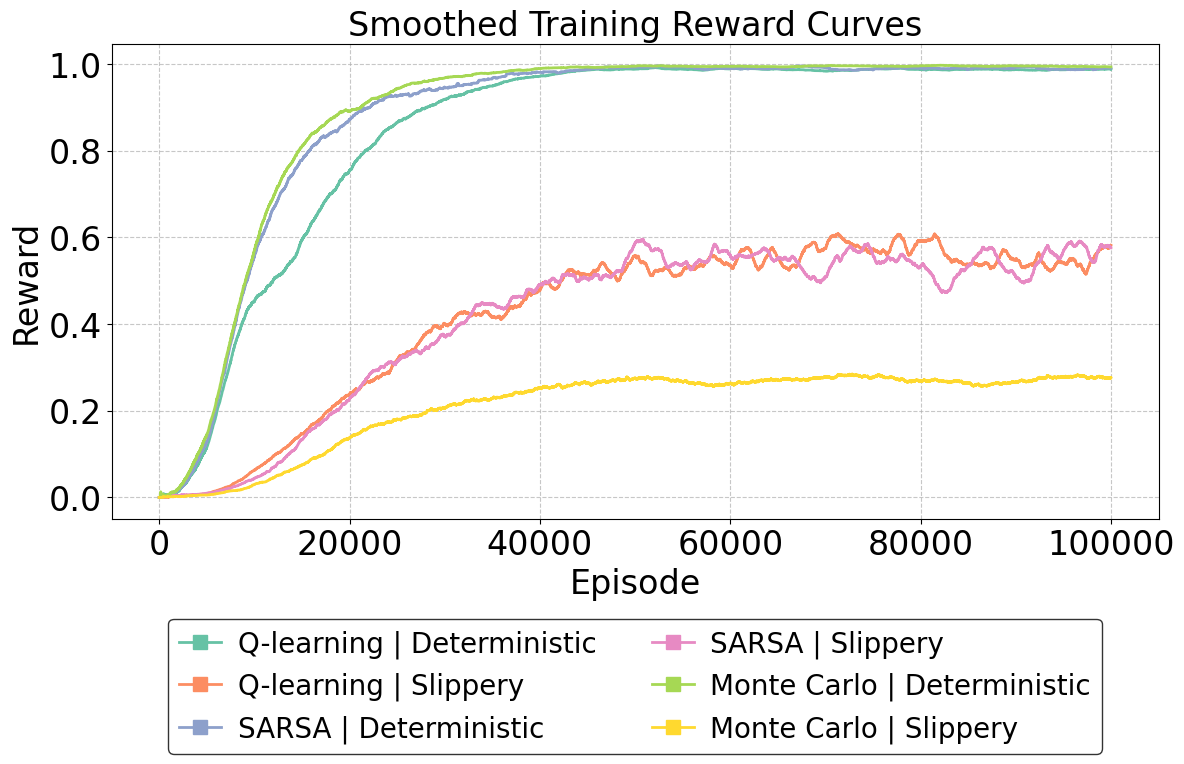

In [ ]:
import matplotlib.pyplot as plt

colors = plt.cm.Set2.colors
labels = list(results.keys())

plt.figure(figsize=(12, 8))

for idx, (label, data) in enumerate(results.items()):
    plot_rewards(data['rewards'], window=5000, label=label, color=colors[idx % len(colors)])

plt.title("Smoothed Training Reward Curves", fontsize=24)
plt.xlabel("Episode", fontsize=24)
plt.ylabel("Reward", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

legend = plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    fontsize=20,
    frameon=True,
    edgecolor='black',
    handlelength=1.5,
    handletextpad=0.6
)

for line in legend.get_lines():
    line.set_marker("s")
    line.set_markersize(10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


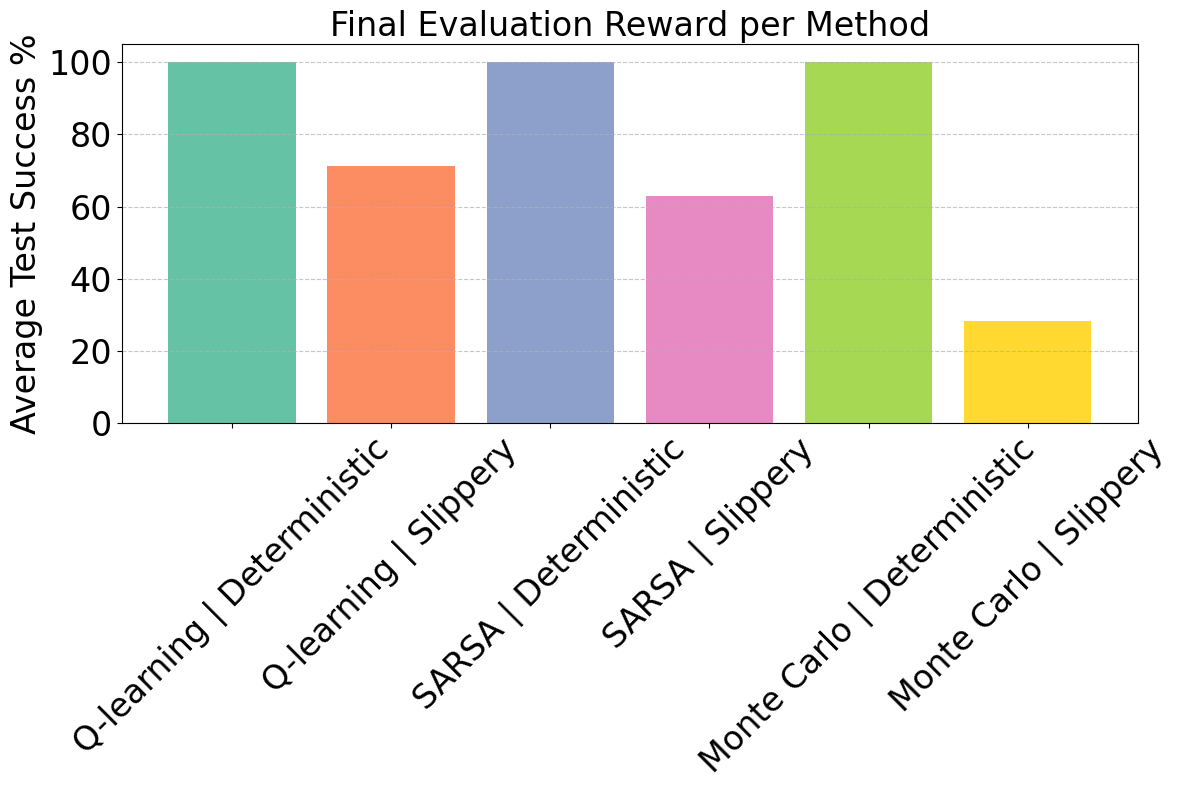

In [ ]:
import matplotlib.pyplot as plt

labels = list(results.keys())
averages = [results[k]['test_success'] for k in labels]

plt.figure(figsize=(12, 8))
colors = plt.cm.Set2.colors

bars = plt.bar(labels, averages, color=colors[:len(labels)])

plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("Average Test Success %", fontsize=24)
plt.title("Final Evaluation Reward per Method", fontsize=24)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
